In [1]:
!pip install scikit-learn==1.1.3 -q

In [2]:
!pip3 install shap

# Обучение с учителем: качество модели

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. Для этого будет обучена модель и предсказаны значения. Описание данных представлено ниже.

market_file.csv - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
    
    id — номер покупателя в корпоративной базе данных.
    Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
    Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
    Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
        Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
    Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
    Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
    Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
    Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
    
market_money.csv - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

    id — номер покупателя в корпоративной базе данных.
    Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
    Выручка — сумма выручки за период.

market_time.csv - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
    
    id — номер покупателя в корпоративной базе данных.
    Период — название периода, во время которого зафиксировано общее время.
    минут — значение времени, проведённого на сайте, в минутах.

money.csv - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

    id — номер покупателя в корпоративной базе данных.
    Прибыль — значение прибыли.

## Загрузка данных

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import shap

RANDOM_STATE = 42
TEST_SIZE = 0.4
TEST_SIZE_VALID = 0.5

In [4]:
market_file=pd.read_csv('/datasets/market_file.csv', sep=',')
market_money=pd.read_csv('/datasets/market_money.csv', sep=',')
market_time=pd.read_csv('/datasets/market_time.csv', sep=',')
money=pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

In [5]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Вывод: файлы были загружены, на экран выведены первые пять строчек каждого датафрейма. Предварительный просмотр данных позволяет понять, что столбцы нуждаются в переименовании.

## Предобработка данных

In [9]:
market_file = market_file.rename(columns={'Покупательская активность': 'пок_активность', 
                                          'Тип сервиса': 'тип_сервиса', 
                                          'Разрешить сообщать': 'разрешить_сообщать', 
                                          'Маркет_актив_6_мес': 'маркет_актив_6_мес', 
                                          'Маркет_актив_тек_мес': 'маркет_актив_тек_мес', 
                                          'Длительность': 'длительность', 
                                          'Акционные_покупки': 'акционные_покупки', 
                                          'Популярная_категория': 'популярная_категория', 
                                          'Средний_просмотр_категорий_за_визит': 'ср_просмотр_категорий_за_визит', 
                                          'Неоплаченные_продукты_штук_квартал': 'неопл_прод_шт_квартал', 
                                          'Ошибка_сервиса': 'ошибка_сервиса',
                                          'Страниц_за_визит': 'страниц_за_визит'})
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1300 non-null   int64  
 1   пок_активность                  1300 non-null   object 
 2   тип_сервиса                     1300 non-null   object 
 3   разрешить_сообщать              1300 non-null   object 
 4   маркет_актив_6_мес              1300 non-null   float64
 5   маркет_актив_тек_мес            1300 non-null   int64  
 6   длительность                    1300 non-null   int64  
 7   акционные_покупки               1300 non-null   float64
 8   популярная_категория            1300 non-null   object 
 9   ср_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неопл_прод_шт_квартал           1300 non-null   int64  
 11  ошибка_сервиса                  1300 non-null   int64  
 12  страниц_за_визит                13

,id,пок_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,ср_просмотр_категорий_за_визит,неопл_прод_шт_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [10]:
categorical_features = ['пок_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for feature in categorical_features:
    market_file[feature] = market_file[feature].str.lower()
    print(f'Уникальные значения в столбце {feature}: {market_file[feature].unique()}')

Уникальные значения в столбце пок_активность: ['снизилась' 'прежний уровень']
Уникальные значения в столбце тип_сервиса: ['премиум' 'стандартт' 'стандарт']
Уникальные значения в столбце разрешить_сообщать: ['да' 'нет']
Уникальные значения в столбце популярная_категория: ['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


Видим, что в столбце "тип сервиса" есть неявные дубликаты: исправим этот момент!

In [11]:
market_file['пок_активность'] = market_file['пок_активность'].map({'снизилась': 1, 'прежний уровень': 0}).fillna(market_file['пок_активность'])
market_file.head()

,id,пок_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,ср_просмотр_категорий_за_визит,неопл_прод_шт_квартал,ошибка_сервиса,страниц_за_визит
0,215348,1,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5
1,215349,1,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5
2,215350,1,стандартт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5
3,215351,1,стандартт,да,3.2,5,896,0.99,товары для детей,5,0,6,4
4,215352,1,стандартт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2


In [12]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [13]:
market_money = market_money.rename(columns={'Период': 'период', 
                                          'Выручка': 'выручка'})
market_money.info()
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [14]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [15]:
market_time = market_time.rename(columns={'Период': 'период',
                                          'минут': 'минуты'})
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минуты  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,период,минуты
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [16]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [17]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдyщий_месяц')
market_time['период'].unique()

array(['текущий_месяц', 'предыдyщий_месяц'], dtype=object)

In [18]:
money = money.rename(columns={'Прибыль': 'прибыль'})
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [19]:
market_file.isna().sum()

id                                0
пок_активность                    0
тип_сервиса                       0
разрешить_сообщать                0
маркет_актив_6_мес                0
маркет_актив_тек_мес              0
длительность                      0
акционные_покупки                 0
популярная_категория              0
ср_просмотр_категорий_за_визит    0
неопл_прод_шт_квартал             0
ошибка_сервиса                    0
страниц_за_визит                  0
dtype: int64

In [20]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [21]:
market_time.isna().sum()

id        0
период    0
минуты    0
dtype: int64

In [22]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

In [23]:
market_file.duplicated().sum()

0

In [24]:
market_money.duplicated().sum()

0

market_time.duplicated().sum()

In [25]:
money.duplicated().sum()

0

Вывод: на данном этапе была проведена предобработка данных: переименованы столбцы и проведена проверка на пропуски и дубликаты, которые не были обнаружены. После этих действий данные готовы к дальнейшей работе с ними.

## Исследовательский анализ данных

Посмотрим, все ли данные, находящиеся в таблице, соответствуют данным пользователям, активным в течение последнего квартала:

In [26]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

В таблице представлены данные только за последний квартал, продолжаем анализ!

In [27]:
invalid_ids = market_money.groupby('id')['выручка'].apply(lambda x: (x == 0).any())
invalid_ids_lst = invalid_ids[invalid_ids].index.tolist()
print(invalid_ids_lst)

[215348, 215357, 215359]


Три покупателя были не совершали покупок хотя бы в течение одного месяца: удалим их из таблицы

In [28]:
market_money = market_money[~market_money['id'].isin(invalid_ids_lst)]
market_money=market_money.reset_index(drop=True)
display(market_money)

,id,период,выручка
0,215349,препредыдущий_месяц,4472.0
1,215349,текущий_месяц,4971.6
2,215349,предыдущий_месяц,5216.0
3,215350,препредыдущий_месяц,4826.0
4,215350,текущий_месяц,5058.4
...,...,...,...
3886,216646,препредыдущий_месяц,4725.0
3887,216646,предыдущий_месяц,4923.0
3888,216647,предыдущий_месяц,4720.0
3889,216647,препредыдущий_месяц,5183.0


Теперь данные актуальны для анализа и мы можем смело переходить к следующему этапу.

## Объединение таблиц

In [29]:
market_money = market_money.pivot_table(index='id', columns='период', values='выручка').reset_index()

market_money.columns = ['id', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 
                        'выручка_текущий_месяц']

display(market_money)

,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7
1293,216644,4729.0,5299.0,5353.0
1294,216645,5160.0,5334.0,5139.2
1295,216646,4923.0,4725.0,5224.6


In [30]:
market_time = market_time.pivot_table(index='id', columns='период', values='минуты', aggfunc='first')
market_time.columns = [f'минуты_{col}' for col in market_time.columns]
market_time = market_time.reset_index()
display(market_time)

,id,минуты_предыдyщий_месяц,минуты_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


In [31]:
merged = pd.merge(market_file, market_money, on='id', how='inner')
merged = pd.merge(merged, market_time, on='id', how='inner')
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1297 non-null   int64  
 1   пок_активность                  1297 non-null   int64  
 2   тип_сервиса                     1297 non-null   object 
 3   разрешить_сообщать              1297 non-null   object 
 4   маркет_актив_6_мес              1297 non-null   float64
 5   маркет_актив_тек_мес            1297 non-null   int64  
 6   длительность                    1297 non-null   int64  
 7   акционные_покупки               1297 non-null   float64
 8   популярная_категория            1297 non-null   object 
 9   ср_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неопл_прод_шт_квартал           1297 non-null   int64  
 11  ошибка_сервиса                  1297 non-null   int64  
 12  страниц_за_визит                12

In [32]:
display(merged)

,id,пок_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,ср_просмотр_категорий_за_визит,неопл_прод_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минуты_предыдyщий_месяц,минуты_текущий_месяц
0,215349,1,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,1,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,1,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,1,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,1,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,0,стандарт,да,6.6,3,318,0.24,техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1293,216644,0,стандарт,нет,5.1,4,454,0.21,домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1294,216645,0,стандарт,да,4.1,3,586,0.20,домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1295,216646,0,стандарт,да,6.3,5,645,0.12,техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [33]:
merged.isna().sum()

id                                0
пок_активность                    0
тип_сервиса                       0
разрешить_сообщать                0
маркет_актив_6_мес                0
маркет_актив_тек_мес              0
длительность                      0
акционные_покупки                 0
популярная_категория              0
ср_просмотр_категорий_за_визит    0
неопл_прод_шт_квартал             0
ошибка_сервиса                    0
страниц_за_визит                  0
выручка_препредыдущий_месяц       0
выручка_предыдущий_месяц          0
выручка_текущий_месяц             0
минуты_предыдyщий_месяц           0
минуты_текущий_месяц              0
dtype: int64

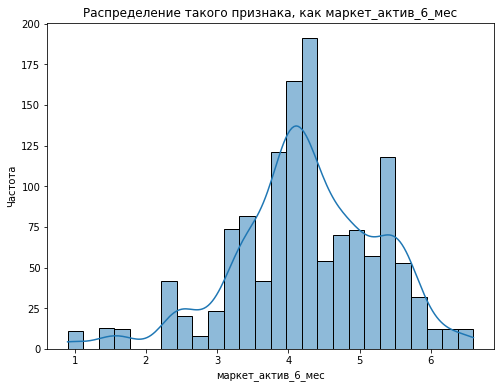

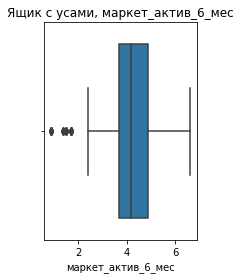

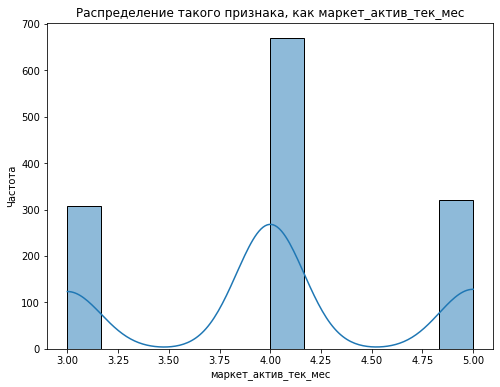

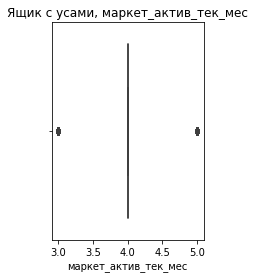

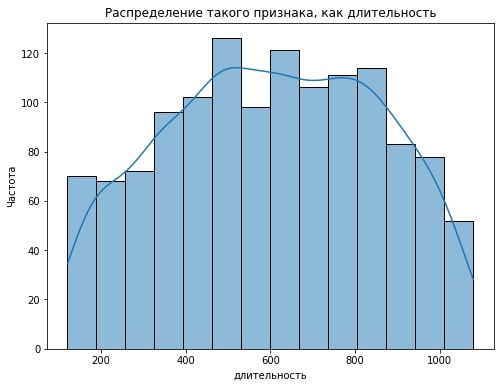

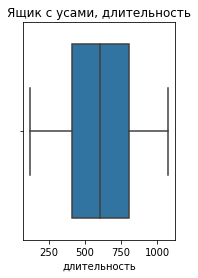

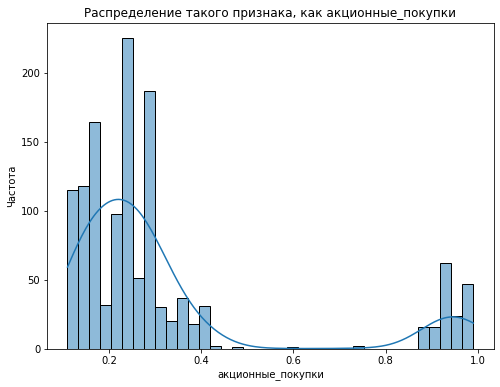

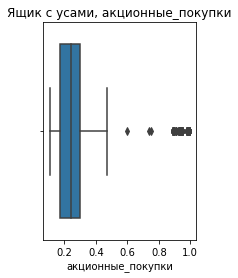

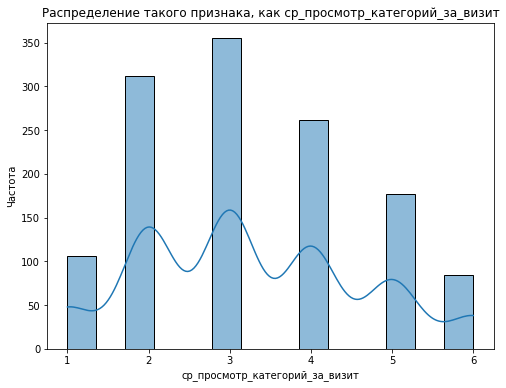

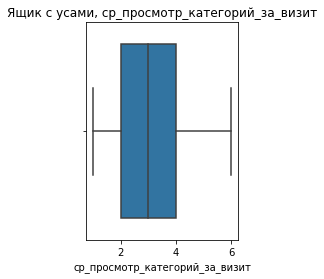

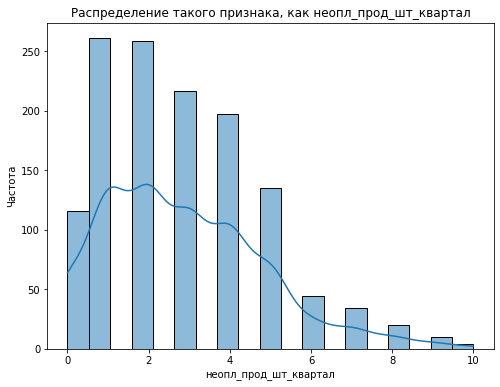

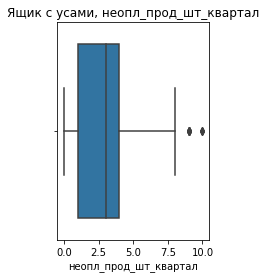

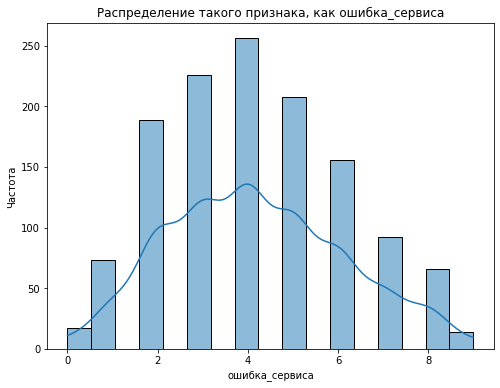

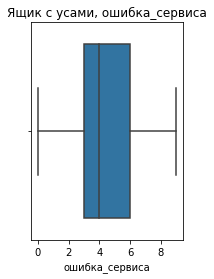

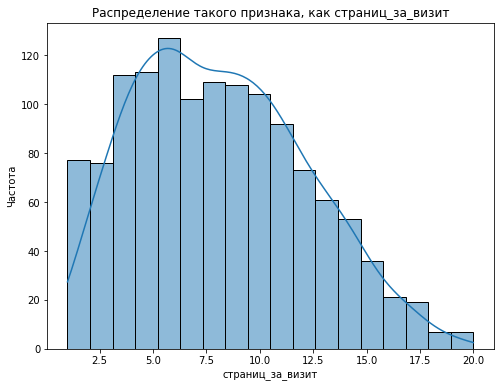

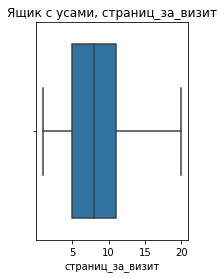

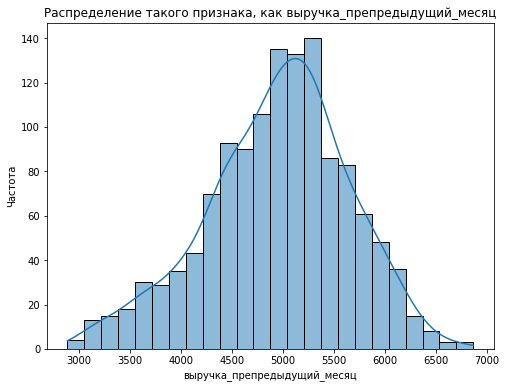

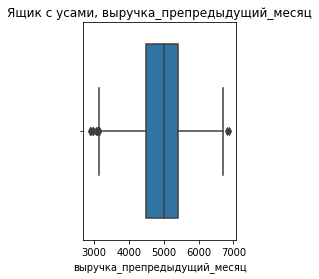

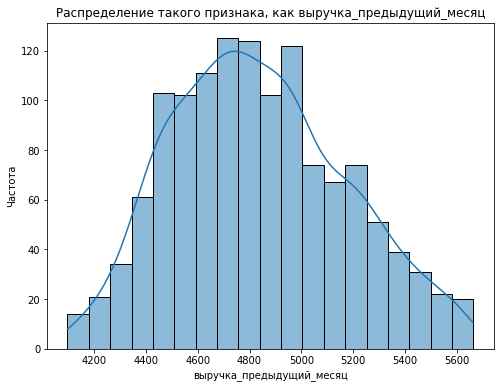

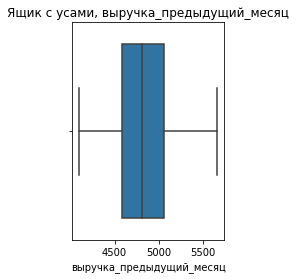

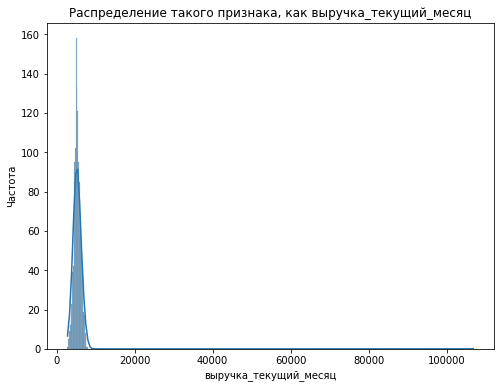

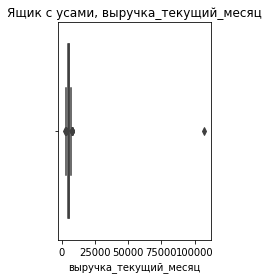

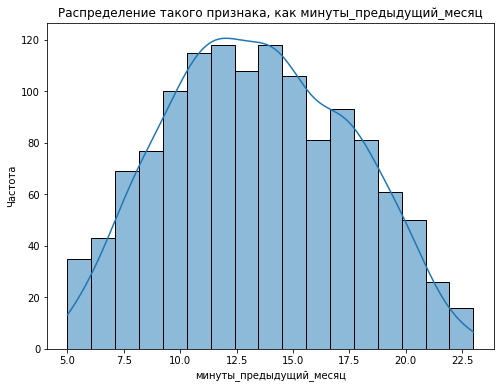

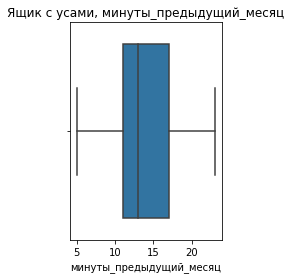

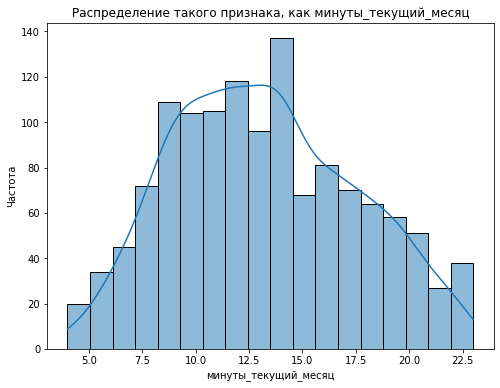

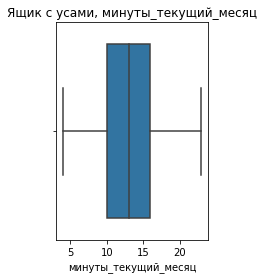

In [34]:
numeric_features=['маркет_актив_6_мес', 'маркет_актив_тек_мес', 
                  'длительность', 'акционные_покупки', 'ср_просмотр_категорий_за_визит',
                  'неопл_прод_шт_квартал','ошибка_сервиса', 'страниц_за_визит', 
                  'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
                  'минуты_предыдyщий_месяц', 'минуты_текущий_месяц']
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(merged[feature], kde=True)
    plt.title(f'Распределение такого признака, как {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=merged[feature])
    plt.title(f'Ящик с усами, {feature}')
    plt.xlabel(feature)
    
    plt.show()

В целом, данные без выбросов: если и есть точки за границами боксплотов, так это потому, что довольно часто реальные значения не укладываются в правило трех сигм. Однако выброс в столбце выручки надо убрать: он даже изменил масштаб ящика с усами..

In [35]:
index_maxx_rev = merged['выручка_текущий_месяц'].idxmax()
merged = merged.drop(index_maxx_rev)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1296 non-null   int64  
 1   пок_активность                  1296 non-null   int64  
 2   тип_сервиса                     1296 non-null   object 
 3   разрешить_сообщать              1296 non-null   object 
 4   маркет_актив_6_мес              1296 non-null   float64
 5   маркет_актив_тек_мес            1296 non-null   int64  
 6   длительность                    1296 non-null   int64  
 7   акционные_покупки               1296 non-null   float64
 8   популярная_категория            1296 non-null   object 
 9   ср_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неопл_прод_шт_квартал           1296 non-null   int64  
 11  ошибка_сервиса                  1296 non-null   int64  
 12  страниц_за_визит                12

Посмотрим на распределение признаков и ящики с усами еще один раз:

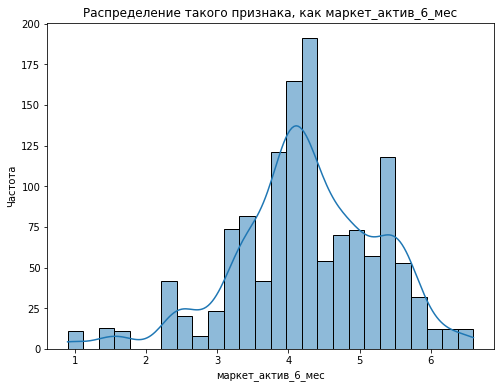

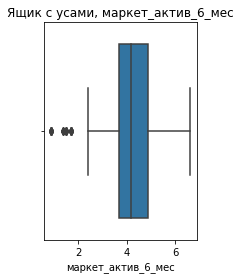

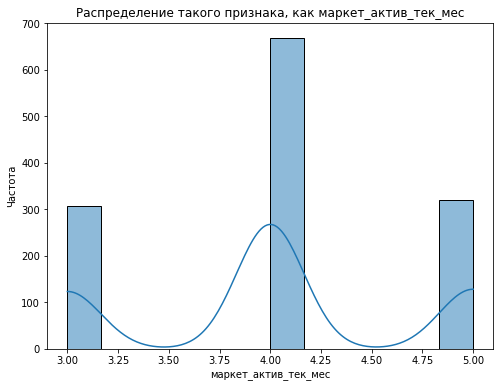

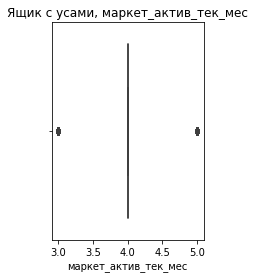

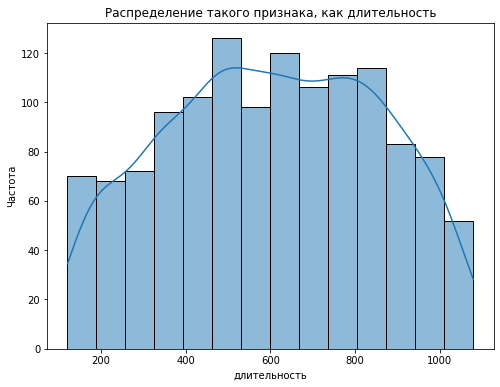

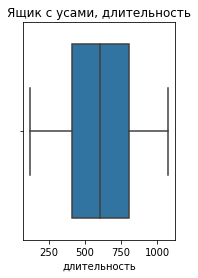

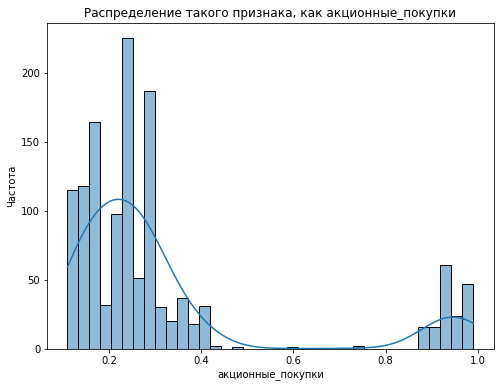

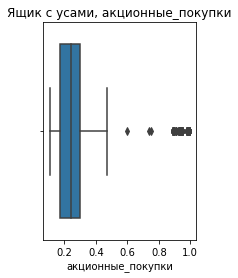

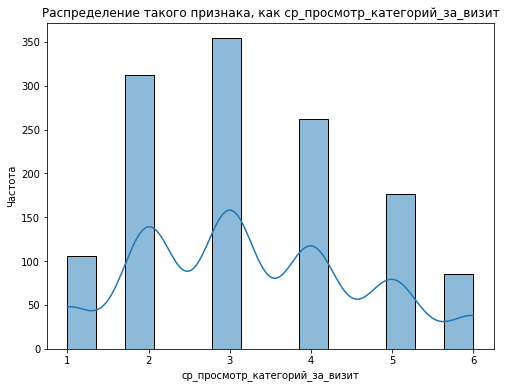

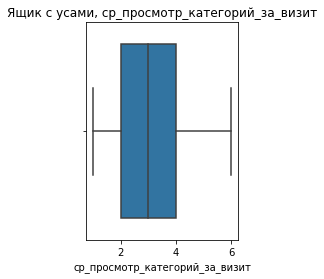

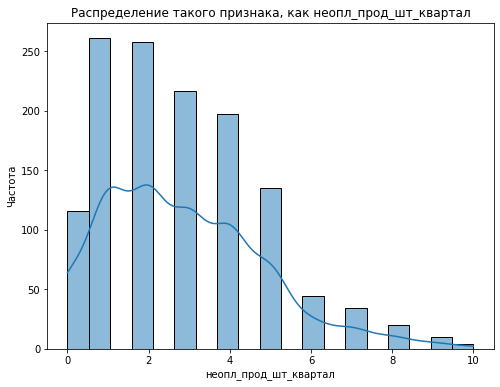

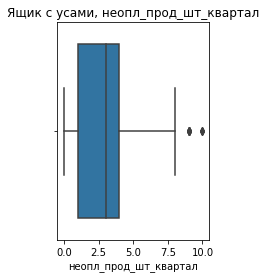

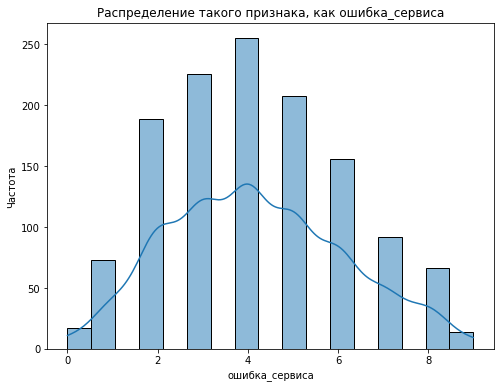

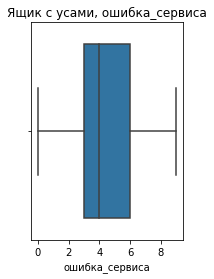

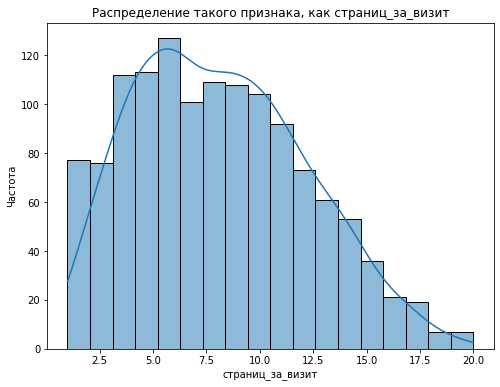

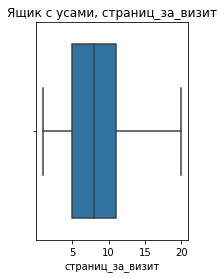

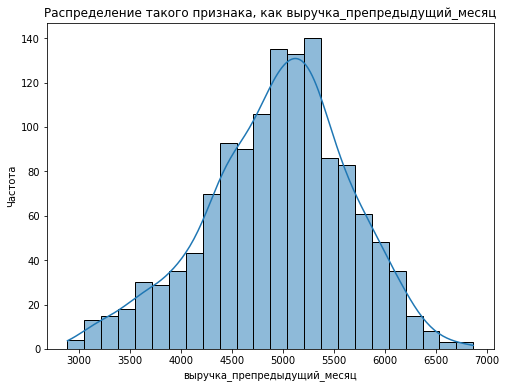

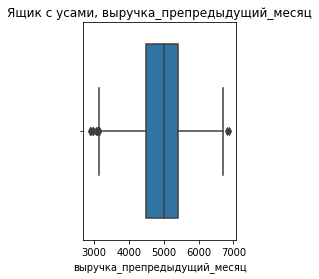

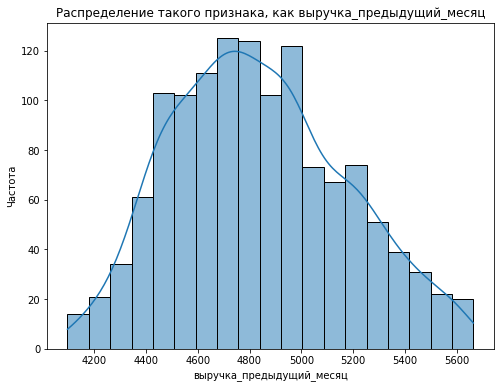

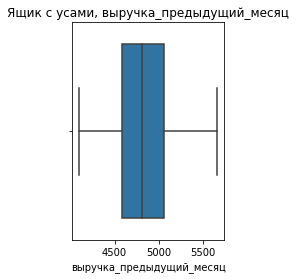

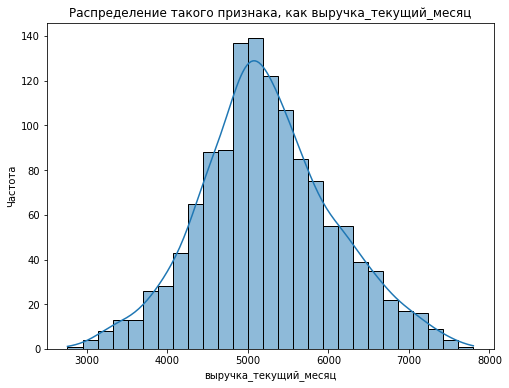

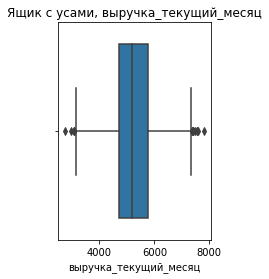

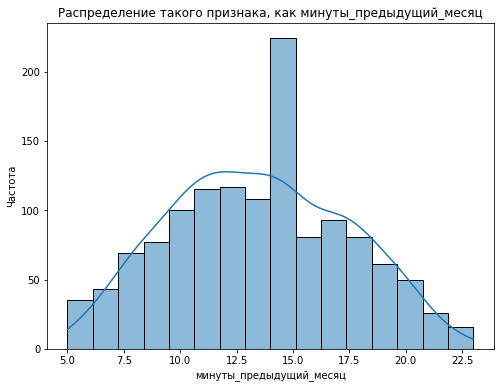

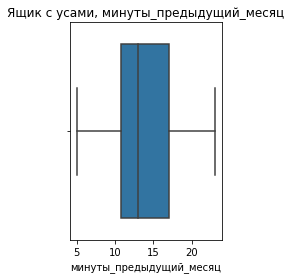

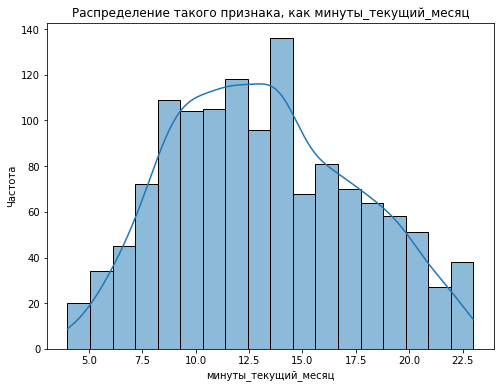

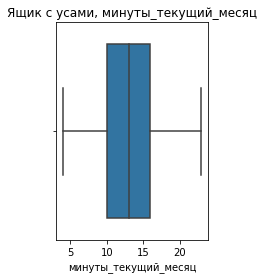

In [36]:
numeric_features=['маркет_актив_6_мес', 'маркет_актив_тек_мес', 
                  'длительность', 'акционные_покупки', 'ср_просмотр_категорий_за_визит',
                  'неопл_прод_шт_квартал','ошибка_сервиса', 'страниц_за_визит', 
                  'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
                  'минуты_предыдyщий_месяц', 'минуты_текущий_месяц']
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(merged[feature], kde=True)
    plt.title(f'Распределение такого признака, как {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=merged[feature])
    plt.title(f'Ящик с усами, {feature}')
    plt.xlabel(feature)
    
    plt.show()

Распределение данных далеко от нормального ;(

## Корреляционный анализ

В связи с ненормальным распределением данным, коэффициент корреляции будет не Пирсона, а Спирмана:

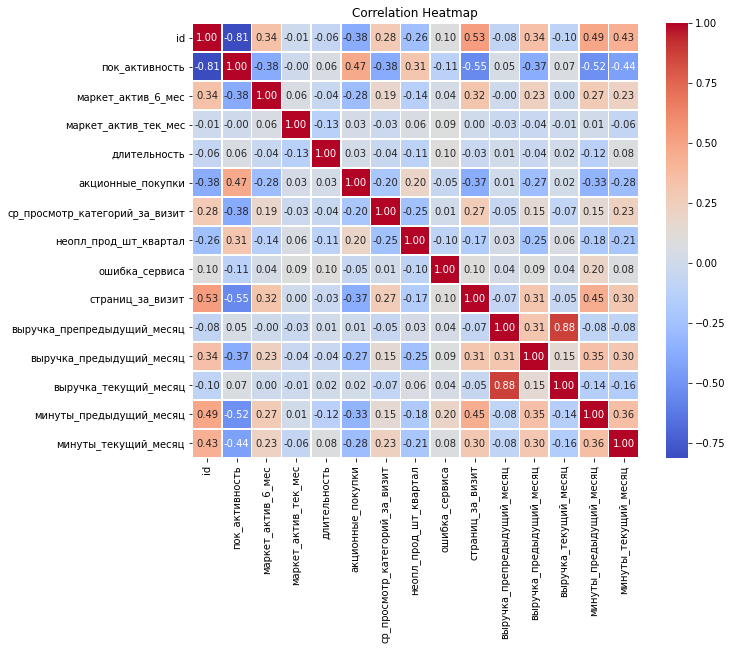

In [37]:
correlation_matrix = merged.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

В полученной матрице корреляции Спирмана находятся коэффициенты, отражающие наличие преимущественно слабых положительных линейных взаимосвязей между переменными, мультиколлинеарности между признаками не наблюдается (нет коэффициентов, превышающих 0.9).

## Шаг 6. Использование пайплайнов

In [38]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(
    merged.drop(['пок_активность'], axis=1),
    merged['пок_активность'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=merged['пок_активность'])

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test_valid,
    y_test_valid,
    test_size=TEST_SIZE_VALID,
    random_state=RANDOM_STATE,
    stratify=y_test_valid)


# создаём списки с названиями признаков
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 
                  'длительность', 'акционные_покупки', 'ср_просмотр_категорий_за_визит',
                  'неопл_прод_шт_квартал','ошибка_сервиса', 'страниц_за_визит', 
                  'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
                  'минуты_предыдyщий_месяц', 'минуты_текущий_месяц']



preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler1', StandardScaler()),
            ('scaler2', MinMaxScaler())
        ]), num_columns),
        ('cat', Pipeline([
            ('onehot', OneHotEncoder())
        ]), ohe_columns + ord_columns)
    ])


knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

knn_param_grid = {
    'classifier__n_neighbors': range(1, 7)
}


dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

dt_param_grid = {
    'classifier__max_depth': [None, 3, 5, 7, 9],
    'classifier__min_samples_split': range(2, 10)
}


lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

lr_param_grid = {
    'classifier__C': [0.1, 1, 10]
}


svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

svc_param_grid = {
    'classifier__C': [0.1, 0.5, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}


knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='roc_auc')
dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='roc_auc')
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring='roc_auc')
svc_grid_search = GridSearchCV(svc_pipeline, svc_param_grid, cv=5, scoring='roc_auc')

knn_grid_search.fit(X_train, y_train)
dt_grid_search.fit(X_train, y_train)
lr_grid_search.fit(X_train, y_train)
svc_grid_search.fit(X_train, y_train)

best_model = max([knn_grid_search, dt_grid_search, lr_grid_search, svc_grid_search], key=lambda x: x.best_score_)
best_model_name = {
    knn_grid_search: 'KNeighborsClassifier',
    dt_grid_search: 'DecisionTreeClassifier',
    lr_grid_search: 'LogisticRegression',
    svc_grid_search: 'SVC'
}[best_model]

print("Лучшая модель:", best_model_name)
print("Лучшие гиперпараметры:", best_model.best_params_)
print("Лучшая оценка на кросс-валидационной выборке:", best_model.best_score_)

Лучшая модель: SVC
Лучшие гиперпараметры: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
Лучшая оценка на кросс-валидационной выборке: 0.9020038538451084


По результатам обучения модели на тренировочных данных и проверке качества работы модели на кросс-валидационной выборке, можно сделать следующий вывод:
    
    лучшая модель - SVC
    лучшие гиперпараметры: C = 0.1, ядро - линейное
    модель верно классифицирует в 90 случаях из 100.
    
Таким образом, для решения поставленной задачи наилучшим способом будет использовать метод опорных векторов с низкой регуляризацией (C = 0.1), так как прослеживались линейные связи между входными и целевым признаками, а также потому что объем данных небольшой. Из четырех предложенных для работы ядер наилучшим оказалось линейное.

## Шаг 7. Анализ важности признаков

Посмотрим, какие признаки наиболее влияют на предсказание покупательской активности клиентов:

In [73]:
feature_names = svc_grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

preprocessor = svc_grid_search.best_estimator_.named_steps['preprocessor']
X_train_sh = preprocessor.fit_transform(X_train.iloc[:, :])
X_test_sh = preprocessor.transform(X_test.iloc[:, :])

explainer = shap.Explainer(svc_grid_search.best_estimator_.named_steps['classifier'].predict_proba, X_train_sh)
shap_values = explainer.shap_values(X_train_sh)

PermutationExplainer explainer: 778it [05:54,  2.13it/s]                         


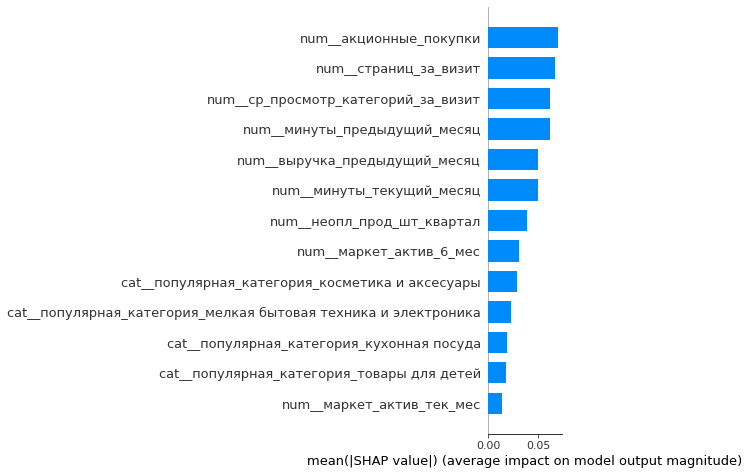

In [76]:
shap.summary_plot(shap_values[:,:,1], plot_type='bar', feature_names=feature_names, max_display=13)

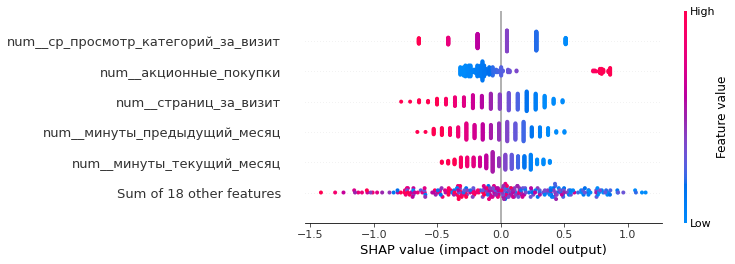

In [78]:
explainer = shap.LinearExplainer(lr_grid_search.best_estimator_.named_steps['classifier'], X_train_sh, feature_names=feature_names)
shap_values = explainer(X_test_sh)

shap.plots.beeswarm(shap_values, max_display = 6)

Вывод: наиболее значимыми оказались такие признаки, как акционные покупки, количество просмотренных страниц за визит, количество просмотренных категорий за визит, количество минут, проведенных на сайте в прошлом месяце и количество выручки, принесенной покупателем в предыдущем месяце. Практически не влияют на целевой признак маркетинговые взаимодействия копмпании с клиентов в течение текущего месяца (рассылки, звонки, показы рекламы), покупки в категории "товары для детей" и "кухонная посуда". При моделировании и принятии бизнес-решений эти наблюдения можно использовать, чтобы понимать, на что стоит обращать большее внимание при построении маркетинговой кампании и формулировании стратегии сбыта продаваемых товаров.

## Шаг 8. Сегментация покупателей

Для анализа выберем сегмент с высокой прибыльностью и высокой вероятностью снижения покупательской активности. Посмотрим, какова средняя и медианная прибыль покупателей за последние три месяца:

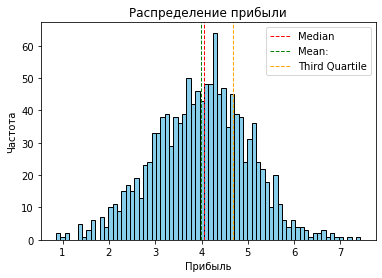

Медиана: 4.045
Среднее: 3.996630769230769
Третий квартиль: 4.67


In [82]:
plt.hist(money['прибыль'], bins=70, color='skyblue', edgecolor='black')

median = money['прибыль'].median()
mean = money['прибыль'].mean()
third_quartile = money['прибыль'].quantile(0.75)

plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.axvline(mean, color='green', linestyle='dashed', linewidth=1, label='Mean:')
plt.axvline(third_quartile, color='orange', linestyle='dashed', linewidth=1, label='Third Quartile')

plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.legend()
plt.title('Распределение прибыли')
plt.show()

print(f'Медиана: {median}')
print(f'Среднее: {mean}')
print(f'Третий квартиль: {third_quartile}')


Таким образом, можно определить границу прибыли от покупателей уровнем выше среднего: возьмем значение в 4.1,  которое будет чуть больше медианного.

Предскажем вероятность снижения покупательской активности каждого клиента компании:

In [61]:
probabilities = best_model.predict_proba(merged)[:, 1]
merged['prob'] = probabilities
display(merged)

,id,пок_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,ср_просмотр_категорий_за_визит,неопл_прод_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минуты_предыдyщий_месяц,минуты_текущий_месяц,prob
0,215349,1,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.962119
1,215350,1,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,0.316281
2,215351,1,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,0.893071
3,215352,1,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,0.942361
4,215353,1,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,0.622105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,0,стандарт,да,6.6,3,318,0.24,техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7,0.085922
1293,216644,0,стандарт,нет,5.1,4,454,0.21,домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11,0.072089
1294,216645,0,стандарт,да,4.1,3,586,0.20,домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18,0.098315
1295,216646,0,стандарт,да,6.3,5,645,0.12,техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7,0.130051


Определим покупателей, относящихся к сегменту с выручкой выше среднего и высокой вероятностью снижения покупательской активности:

In [62]:
money_filtered = money[money['прибыль'] > 4.1]
merged_filtered = merged[merged['prob'] > 0.8]

result = pd.merge(money_filtered, merged_filtered, on='id')
display(result)

,id,прибыль,пок_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,ср_просмотр_категорий_за_визит,неопл_прод_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минуты_предыдyщий_месяц,минуты_текущий_месяц,prob
0,215349,4.16,1,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.962119
1,215351,4.87,1,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,0.893071
2,215352,4.21,1,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,0.942361
3,215356,4.93,1,стандарт,да,4.2,4,192,0.14,косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,0.966127
4,215368,6.27,1,премиум,да,3.8,5,829,0.24,техника для красоты и здоровья,2,2,6,1,5823.0,4536.0,5591.6,11,9,0.863953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,216383,4.65,0,стандарт,да,4.3,5,748,0.95,косметика и аксесуары,3,1,6,6,4823.5,4615.0,5134.2,19,7,0.900342
161,216397,4.75,0,стандарт,да,4.2,5,199,0.94,товары для детей,4,2,6,4,3846.0,4471.0,4518.1,14,11,0.905546
162,216564,5.58,0,стандарт,да,5.6,4,342,0.94,кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,0.825064
163,216607,4.91,0,стандарт,да,3.3,4,575,0.23,товары для детей,2,4,5,8,4991.0,4463.0,5578.6,11,12,0.876704


In [63]:
target_ids=result['id'].unique()
print(f'Количество клиентов рассматриваемого сегмента: {len(target_ids)}')
print(f'ID клиентов рассматриваемого сегмента: {target_ids}')

Количество клиентов рассматриваемого сегмента: 165
ID клиентов рассматриваемого сегмента: [215349 215351 215352 215356 215368 215375 215376 215377 215379 215383
 215384 215388 215389 215391 215396 215398 215399 215400 215401 215402
 215406 215410 215413 215416 215417 215418 215419 215422 215425 215426
 215428 215430 215432 215437 215439 215440 215443 215449 215452 215456
 215457 215459 215460 215461 215464 215468 215471 215472 215473 215478
 215481 215484 215485 215486 215494 215496 215497 215499 215500 215503
 215505 215506 215510 215511 215512 215514 215519 215523 215524 215525
 215526 215527 215532 215540 215541 215542 215546 215550 215552 215555
 215556 215561 215563 215565 215568 215570 215573 215576 215577 215582
 215583 215584 215585 215586 215589 215591 215594 215595 215596 215600
 215601 215602 215603 215604 215606 215607 215608 215609 215612 215613
 215615 215619 215620 215621 215626 215627 215628 215636 215638 215639
 215640 215641 215643 215648 215649 215651 215652 215658 2

In [64]:
all_ids = merged['id'].unique()
ids_to_keep = set(all_ids) - set(result['id'])
result_2 = merged[merged['id'].isin(ids_to_keep)]

result_2.reset_index(drop=True, inplace=True)
display(result_2)

,id,пок_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,ср_просмотр_категорий_за_визит,неопл_прод_шт_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минуты_предыдyщий_месяц,минуты_текущий_месяц,prob
0,215350,1,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,0.316281
1,215353,1,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,0.622105
2,215354,1,стандарт,да,5.1,3,431,0.23,косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12,0.863149
3,215355,1,стандарт,нет,4.7,4,284,0.17,товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10,0.275376
4,215358,1,стандарт,да,4.7,4,450,0.13,домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10,0.291347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,216643,0,стандарт,да,6.6,3,318,0.24,техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7,0.085922
1127,216644,0,стандарт,нет,5.1,4,454,0.21,домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11,0.072089
1128,216645,0,стандарт,да,4.1,3,586,0.20,домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18,0.098315
1129,216646,0,стандарт,да,6.3,5,645,0.12,техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7,0.130051


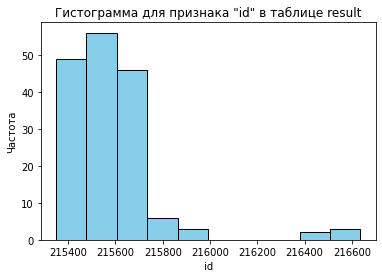

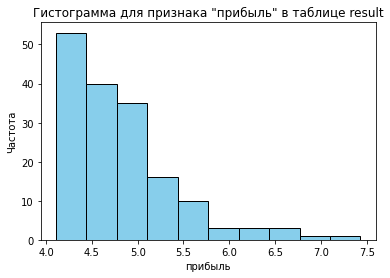

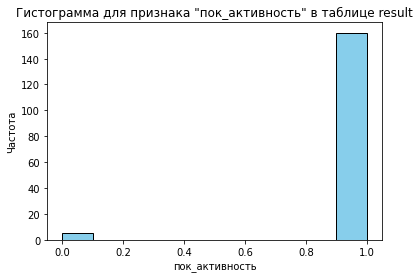

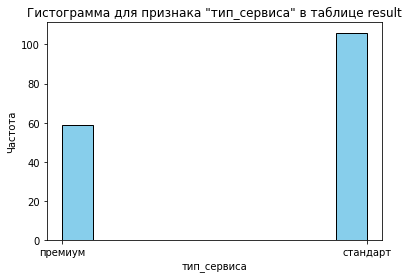

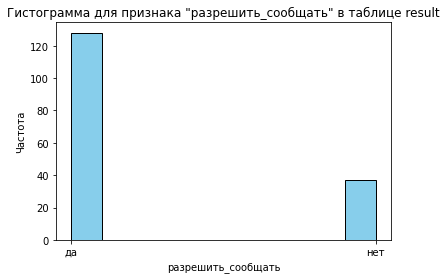

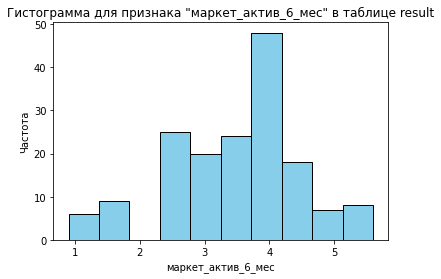

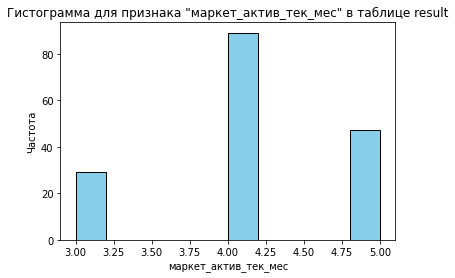

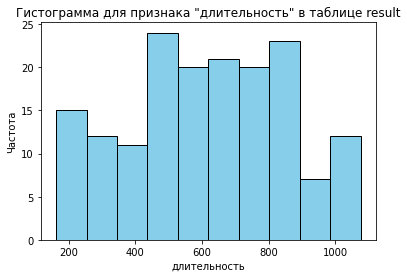

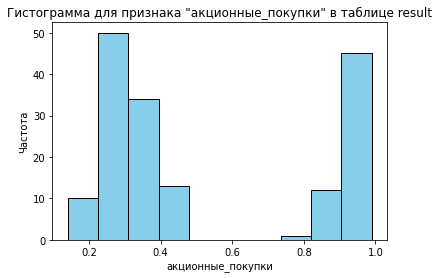

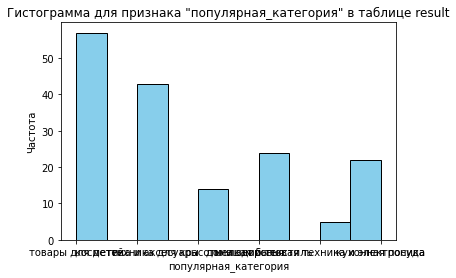

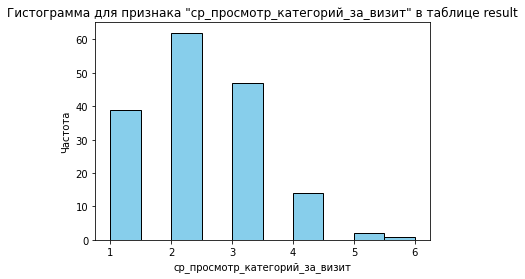

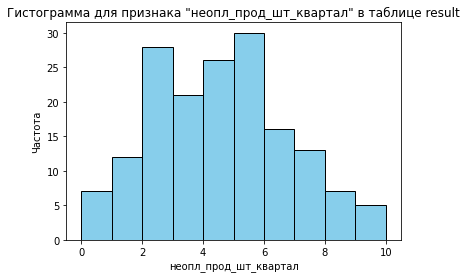

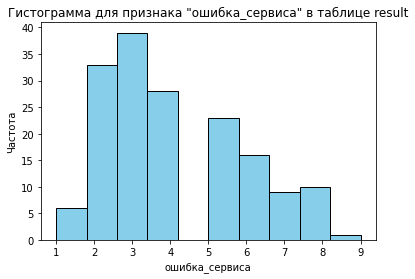

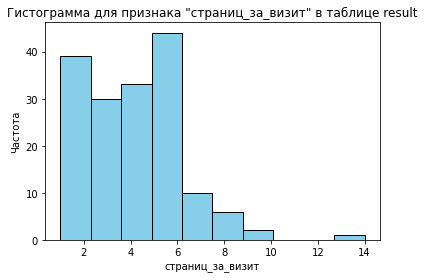

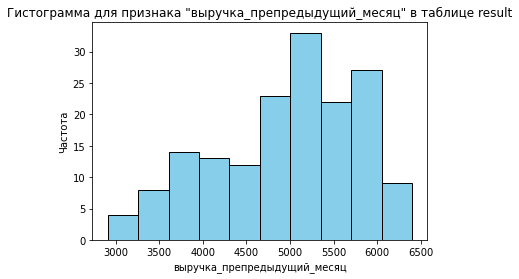

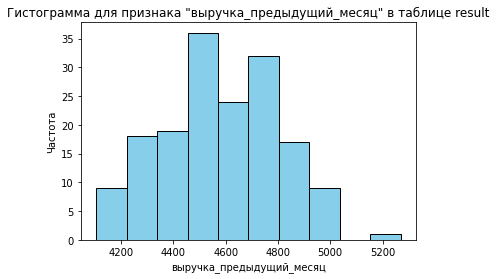

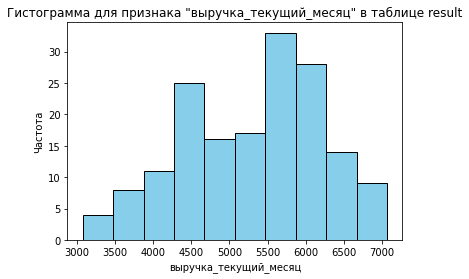

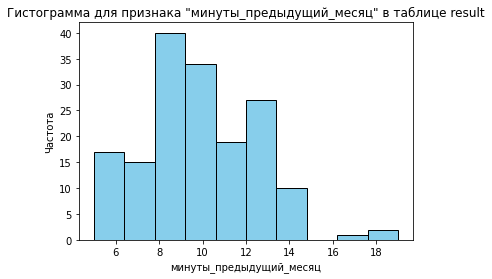

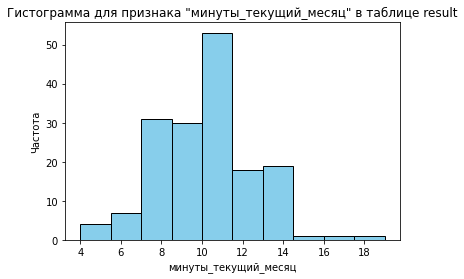

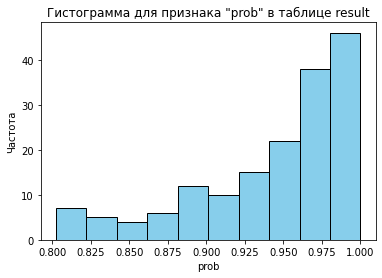

In [65]:
for column in result.columns:
    plt.hist(result[column], bins=10, color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для признака "{column}" в таблице result')
    plt.show()

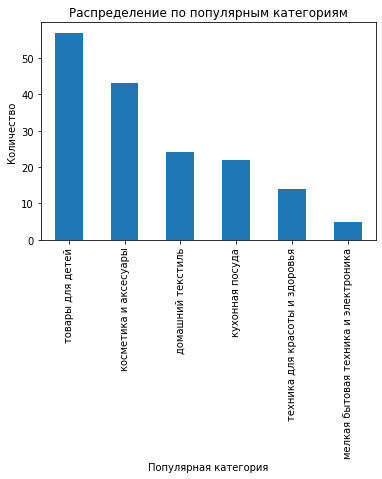

In [68]:
result['популярная_категория'].value_counts().plot(kind='bar')
plt.xlabel('Популярная категория')
plt.ylabel('Количество')
plt.title('Распределение по популярным категориям')
plt.show()

Из полученных гистограмм видно, что клиенты анализируемого сегмента в большинстве своем пользуются стандартным типом сервиса, разрешают отправлять им дополнительные сведения о товаре, в среднем получали 4 маркетинговых коммуникации в месяц за последние полгода, преимущественно активны на сайте 400-900 дней; акционные покупки для большинства составляют всего 20% от общего числа покупок, в среднем просматривают 2-3 категории за один визит на сайт, наиболее часто имеют шесть неоплаченных товаров в корзине, чаще всего сталкиваются со сбоями в работе сайта три раза и посещают шесть страниц за визит, проводят на сайте 8-10 минут и по популярности категории товаров делят следующим образом (по убыванию популярности): товары для детей, косметика и аксессуары, домашний текстиль, кухонная посуда, техника для красоты и здоровья, мелкая бытовая техника и электроника.

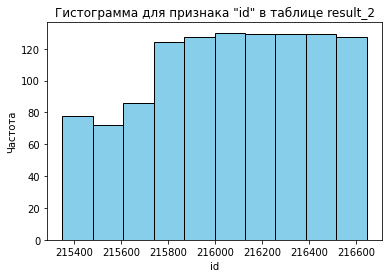

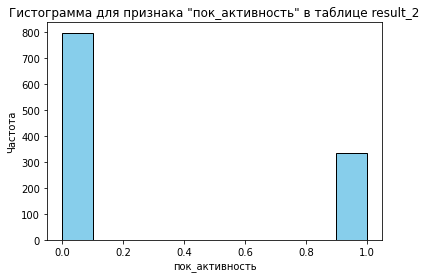

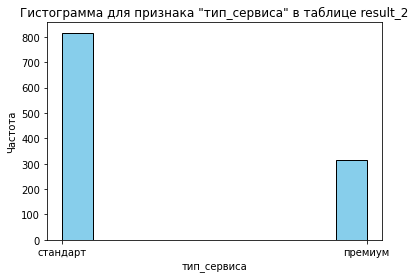

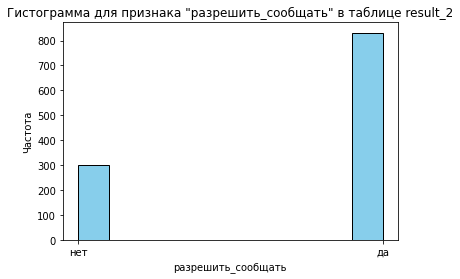

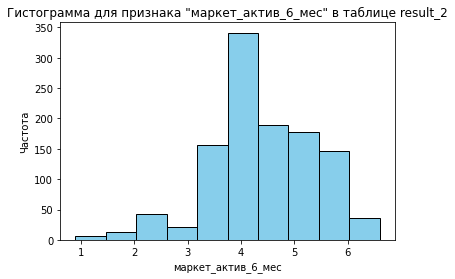

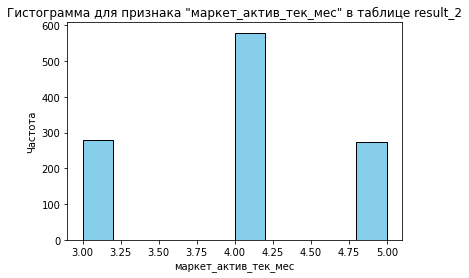

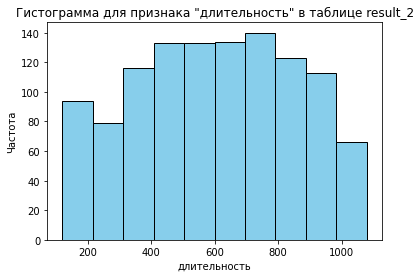

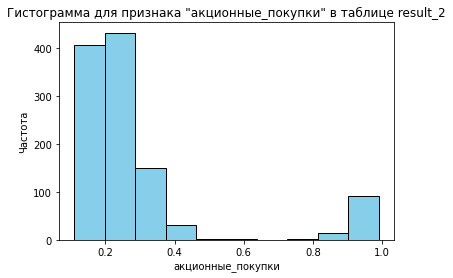

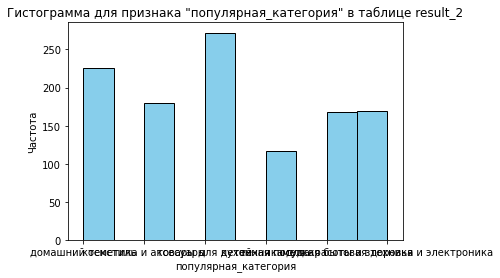

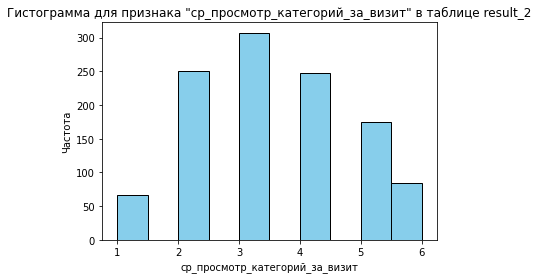

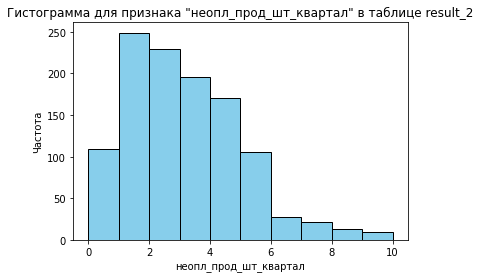

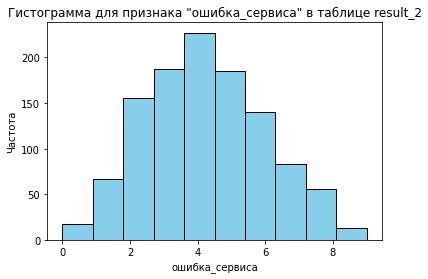

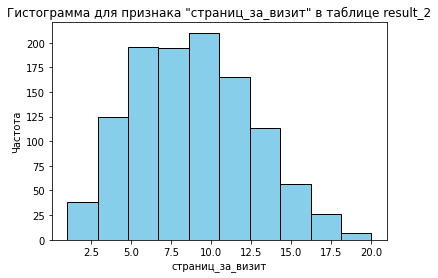

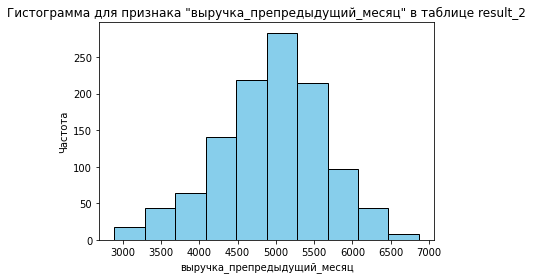

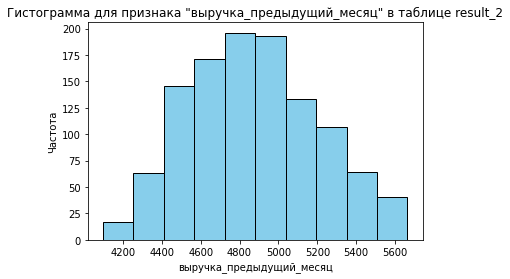

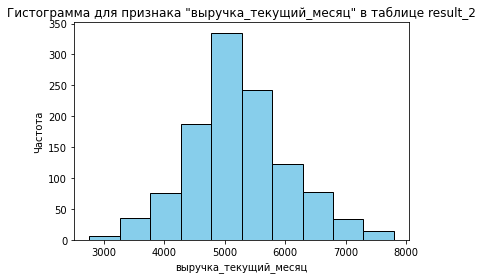

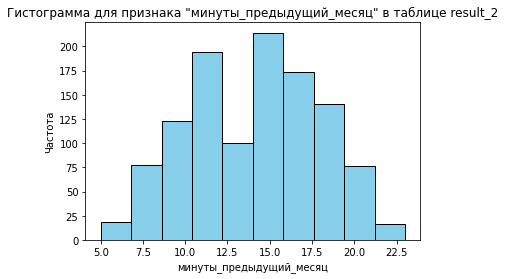

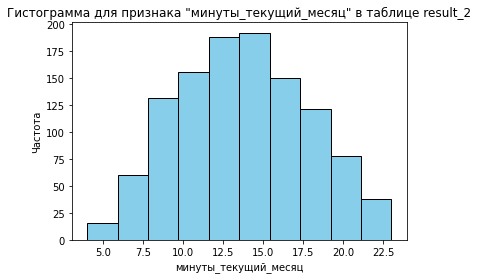

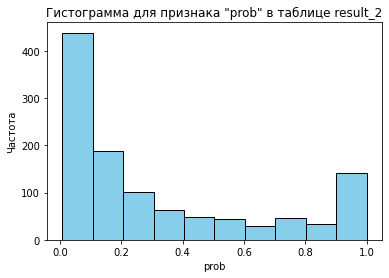

In [66]:
for column in result_2.columns:
    plt.hist(result_2[column], bins=10, color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для признака "{column}" в таблице result_2')
    plt.show()

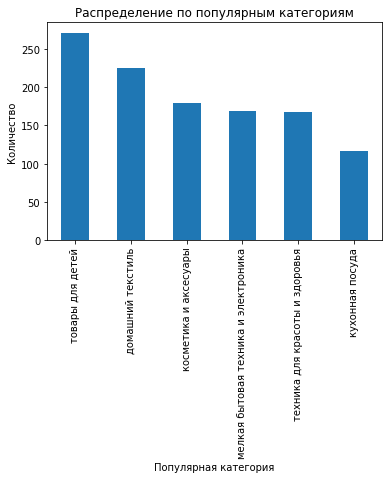

In [70]:
result_2['популярная_категория'].value_counts().plot(kind='bar')
plt.xlabel('Популярная категория')
plt.ylabel('Количество')
plt.title('Распределение по популярным категориям')
plt.show()

Из полученных гистограмм видно, что клиенты, не попавшие в анализируемый сегмент тоже пользуются стандартным типом сервиса, разрешают отправлять им дополнительную информацию о товаре, в среднем получали 4 маркетинговых коммуникации в месяц за последние полгода, преимущественно активны на сайте 400-700 дней; акционные покупки для большинства составляют 10-20% от общего числа покупок, в среднем просматривают 3 категории за один визит на сайт, наиболее часто имеют два неоплаченных товара в корзине, чаще всего сталкиваются со сбоями в работе сайта четыре раза раза и посещают десять страниц за визит, проводят на сайте 15 минут и по популярности категории товаров делят следующим образом (по убыванию популярности): товары для детей, домашний текстиль, косметика и аксессуары, мелкая бытовая техника и электроника, техника для красоты и здоровья, кухонная посуда,

Таким образом, подытожим отличия между клиентами: 

Во-первых, клиенты анализируемого сегмента в среднем проводят на сайте меньше времени (8-10 минут), в то время как те, кто не вошел в сегмент, проводят на нем больше времени (15 минут). Во-вторых, акционные покупки для клиентов из анализируемого сегмента составляют 20% от общего числа покупок, в то время как для остальных клиентов это значение колеблется между 10% и 20%. В-третьих, клиенты из анализируемого сегмента реже сталкиваются с сбоями в работе сайта три раза за визит, в то время как остальные клиенты в среднем сталкиваются с сбоями в четыре раза. И наконец, по популярности категорий товаров у обеих групп клиентов есть общие черты, такие как товары для детей и электроника, но в анализируемом сегменте косметика и аксессуары, домашний текстиль и кухонная посуда также имеют высокую популярность, в то время как для остальных клиентов домашний текстиль и косметика занимают более высокие позиции.

На основе сравнения, разумным рекомендовать компании формировать персонализированную ленту с товарами для каждого клиента, что увеличит проведенное время на сайте (люди будут изучать интересные им продукты), а это, исходя из анализа важности признаков модели, важно для формирования покупательской активности. Также очень важным является формирования акционных предложений, так как в анализируемом сегменте такие товары пользуются особым спросом и также значительно влияют на формирование покупательской активности. 

Самой популярной категорией являются товары для детей, что делает логичным их продвижение для любого клиента компании.

## Шаг 9. Общий вывод

Во время работы над проектом был проведен исследовательский и статистический анализ данных с их предварительной предобработкой. Были рассмотрены и проанализированы несколько моделей машинного обучения для предсказания целевого признака, а также рассмотрены различные гиперпараметры для каждой из них. 

По итогу обучение и предсказание покупательской активности производилось с помощью метода опорных векторов с низкой регуляризацией (С = 0.1) и линейным ядром. 

Сегментация клиентов производилась с помощью их отбора по выручке выше средней медианной за последний квартал и отбором вероятности принадлежности к классу 1 (снижение покупательской активности) больше 0.8, чтобы точно определить тех, кто находятся в "зоне рика" уменьшения стоимости покупок в рассматриваемой компании.

Были сделаны выводы и даны рекомендации на каждом из этапов работы над проектом.